In [1]:
# Update packages.
!pip uninstall -y tensorflow tensorflow-datasets
!pip install --upgrade -q jax==0.1.70 jaxlib==0.1.48 flax==0.1.0 tf-nightly tfds-nightly

Uninstalling tensorflow-2.3.0:
  Successfully uninstalled tensorflow-2.3.0
Uninstalling tensorflow-datasets-2.1.0:
  Successfully uninstalled tensorflow-datasets-2.1.0
     |████████████████████████████████| 378kB 3.4MB/s 
     |████████████████████████████████| 32.4MB 151kB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 344.9MB 45kB/s 
     |████████████████████████████████| 3.5MB 40.4MB/s 
     |████████████████████████████████| 9.0MB 40.5MB/s 
     |████████████████████████████████| 460kB 45.3MB/s 


## Imports

In [1]:
import collections
import functools
import importlib
import math
import os
import tempfile
from typing import Any, Callable, Dict, Iterable, List, Mapping, Optional, Tuple
from dataclasses import dataclass, field
import flax
from flax import nn, jax_utils
from flax.training import checkpoints 
import jax
import jax.numpy as jnp
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import itertools
from flax.nn.initializers import normal

## Connect to TPU

⚠️ Make sure the Colab Runtime is set to Accelerator: TPU.<br>
Menu: _Runtime --> Change runtime type_<br>
Popup: _Hardware Accelerator --> TPU_<br>


In [2]:
import requests

if "TPU_DRIVER_MODE" not in globals():
  url = "http://" + os.environ["COLAB_TPU_ADDR"].split(":")[0] + ":8475/requestversion/tpu_driver_nightly"
  resp = requests.post(url)
  TPU_DRIVER_MODE = 1

# The following is required to use TPU Driver as JAX"s backend.
jax.config.FLAGS.jax_xla_backend = "tpu_driver"
jax.config.FLAGS.jax_backend_target = "grpc://" + os.environ["COLAB_TPU_ADDR"]

print("JAX devices:\n" + "\n".join([repr(d) for d in jax.devices()]))

JAX devices:
TpuDevice(id=0, host_id=0, coords=(0,0,0), core_on_chip=0)
TpuDevice(id=1, host_id=0, coords=(0,0,0), core_on_chip=1)
TpuDevice(id=2, host_id=0, coords=(1,0,0), core_on_chip=0)
TpuDevice(id=3, host_id=0, coords=(1,0,0), core_on_chip=1)
TpuDevice(id=4, host_id=0, coords=(0,1,0), core_on_chip=0)
TpuDevice(id=5, host_id=0, coords=(0,1,0), core_on_chip=1)
TpuDevice(id=6, host_id=0, coords=(1,1,0), core_on_chip=0)
TpuDevice(id=7, host_id=0, coords=(1,1,0), core_on_chip=1)


## Authenticate

Authenticating with your google.com account will enable you to read the TFDS datasets directly from TFDS.

Run this to authenticate with your google.com account. You will be asked top open a link, sign in with your Google account and copy
paste the code to here.

**Make sure to set the `TFDS_DATA_DIR` environment variable to the path where the datasets can be found.**

In [3]:
from google.colab import auth
auth.authenticate_user()

# If you authenticated successfully this should now work and list >100 datasets.
TFDS_DATA_DIR = os.getenv("TFDS_DATA_DIR")
print(f"Found {len(tf.io.gfile.listdir(TFDS_DATA_DIR))} datasets.")

Found 233 datasets.


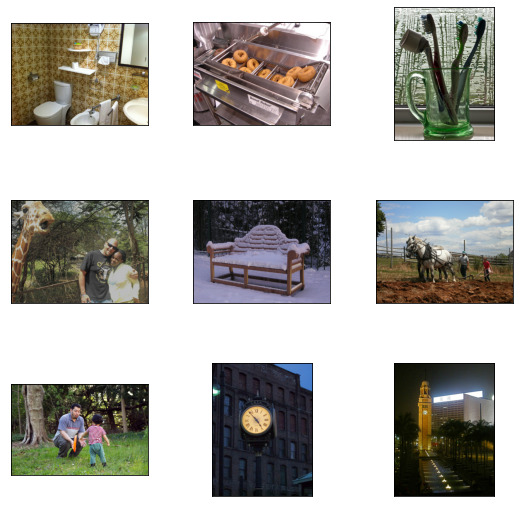

In [4]:
ds, ds_info = tfds.load("coco/2014", split="train", with_info=True, data_dir=TFDS_DATA_DIR)
_ = tfds.visualization.show_examples(ds, ds_info)

## Auxiliary Code

This section contains auxiliary code which is useful for running the input pipeline.

In [5]:
#@title
def pi_init(pi):
  """Wrapper to log-based weight initializer function.

  This initializer is used for the bias term in the classification subnet, as
  described in https://arxiv.org/abs/1708.02002

  Args:
    pi: the prior probability of detecting an object

  Returns:
    An array for initializing a module's weights / biases
  """

  def _inner(key, shape, dtype=jnp.float32):
    return jnp.ones(shape, dtype) * (-jnp.log((1 - pi) / pi))

  return _inner


def get_intersection(rect1, rect2):
  """Computes the intersection between two rectangles.

  Args:
    rect1: a list or tuple, which contains the coordinates of the top left and
           bottom right corners respectively: [x1, y1, x2, y2].
    rect2: a list or tuple, which contains the coordinates of the top left and
           bottom right corners respectively: [x1, y1, x2, y2].

  Returns:
    The area of the intersection of the two rectangles
  """
  overlap_x = max(0, min(rect1[2], rect2[2]) - max(rect1[0], rect2[0]))
  overlap_y = max(0, min(rect1[3], rect2[3]) - max(rect1[1], rect2[1]))
  return overlap_x * overlap_y


def jaccard_index(rect1, rect2):
  """Compute the Jaccard index of two rectangles.

  Args:
    rect1: a list or tuple, which contains the coordinates of the top left and
           bottom right corners respectively: [x1, y1, x2, y2].
    rect2: a list or tuple, which contains the coordinates of the top left and
           bottom right corners respectively: [x1, y1, x2, y2].

  Returns:
    The IoU of the two rectangles
  """
  # Get the intersection
  intersection = get_intersection(rect1, rect2)

  # Get the union value
  area1 = (rect1[2] - rect1[0]) * (rect1[3] - rect1[1])
  area2 = (rect2[2] - rect2[0]) * (rect2[3] - rect2[1])
  union = area1 + area2 - intersection

  # Return the IoU
  return intersection / union


@tf.function
def tf_jaccard_index(rects: tf.Tensor):
  rect1 = rects[0]
  rect2 = rects[1]

  # Compute the overlap on the X axis
  left_x = tf.math.maximum(rect1[0], rect2[0])
  right_x = tf.math.minimum(rect1[2], rect2[2])
  overlap_x = tf.math.maximum(0.0, right_x - left_x)

  # Compute the overlap on the Y axis
  lo_y = tf.math.maximum(rect1[1], rect2[1])
  hi_y = tf.math.minimum(rect1[3], rect2[3])
  overlap_y = tf.math.maximum(0.0, hi_y - lo_y)

  # Compute the area of the intersection
  intersection = overlap_x * overlap_y

  # Compute the area of the union
  area1 = (rect1[2] - rect1[0]) * (rect1[3] - rect1[1])
  area2 = (rect2[2] - rect2[0]) * (rect2[3] - rect2[1])
  union = area1 + area2 - intersection

  # Return the IoU
  return intersection / union


def non_max_suppression(bboxes, scores, t):
  """Implements the Non-Maximum Suppression algorithm.

  More specifically, this algorithm retains the bboxes based on their scores 
  (those that have a higher score are favored), and IoU's with the other bboxes
  (bboxes that have a high overlap with bboxes with higher scores are removed).

  Args:
    bboxes: a matrix of the form (|B|, 4), where |B| is the number of bboxes,
      and the columns represent the coordinates of each bbox: [x1, y1, x2, y2]
    scores: a vector of the form (|B|,) storing the confidence in each bbox
    t: the IoU threshold; overlap above this threshold with higher scoring 
      bboxes will imply the lower scoring bbox should be discarded

  Returns:
    The indexes of the bboxes which are retained after NMS is applied.
  """
  selected_idx = []
  
  # Split the bboxes so they're easier to manipulate throughout
  x1 = jnp.array(bboxes[:, 0])
  y1 = jnp.array(bboxes[:, 1])
  x2 = jnp.array(bboxes[:, 2])
  y2 = jnp.array(bboxes[:, 3])
  
  sorted_idx = jnp.argsort(scores)
  areas = (x2 - x1 + 1) * (y2 - y1 + 1)

  while sorted_idx.shape[0] > 0:
    # Select the index of the bbox with the highest score  
    current = sorted_idx[-1]
    selected_idx.append(current)

    # Determine the height and width of the intersections with the current bbox
    xx1 = jnp.maximum(x1[current], x1[sorted_idx[:-1]])
    yy1 = jnp.maximum(y1[current], y1[sorted_idx[:-1]])
    xx2 = jnp.minimum(x2[current], x2[sorted_idx[:-1]])
    yy2 = jnp.minimum(y2[current], y2[sorted_idx[:-1]])

    width = jnp.maximum(0.0, xx2 - xx1 + 1)
    height = jnp.maximum(0.0, yy2 - yy1 + 1)

    # Compute the IoU between the current bbox and all the other bboxes
    intersection = width * height
    ious = intersection / (areas[current] + areas[sorted_idx[:-1]] - intersection)

    # Keep only the bboxes with the lower threshold
    sorted_idx = sorted_idx[jnp.where(ious < t)[0]]

  # Return the indexes of the non-suppressed bboxes
  selected_idx = jnp.array(selected_idx, dtype=jnp.int32)
  return jnp.array(bboxes[selected_idx, :]), selected_idx



In [6]:
#@title
@dataclass
class AnchorConfig:
  """This class contains the necessary information for unpacking anchors.

  It should be mentioned that the length of `sizes` and `strides` must be equal
  to the number of layers in RetinaNet's head. `scales` and `ratios` are lists
  of arbitrary lengths.
  """
  levels: list = field(default_factory=lambda: [3, 4, 5, 6, 7])
  sizes: list = field(default_factory=lambda: [32, 64, 128, 256, 512])
  strides: list = field(default_factory=lambda: [8, 16, 32, 64, 128])
  ratios: list = field(default_factory=lambda: [0.5, 1, 2])
  scales: list = field(
      default_factory=lambda: [1.0, 2.0**(1.0 / 3.0), 2.0**(2.0 / 3.0)])


def generate_base_anchors(size, ratios, scales, dtype=jnp.float32):
  """Generates candidate anchor shapes.

  Args:
    size: the size of the anchor box
    ratios: the aspect ratio of the anchor boxes
    scales: the scales of the anchor boxes
    dtype: the data type of the output

  Returns:
    The expanded anchors. The result will have the shape
    (|ratios| * |scales|, 4), where the elements on each row represent the
    upper left and lower right corners of the anchor box. The coordinates are
    relative to the origin, which is located in the center of the anchor box.
  """
  ratios = jnp.array(ratios, dtype=dtype)
  scales = jnp.array(scales, dtype=dtype)

  # Scales are replicated to enable vectorized computations
  adjusted_size = jnp.tile(scales, (2, ratios.shape[0])).T * size

  # The areas are required for extracting the correct height and width
  areas = adjusted_size[:, 0] * adjusted_size[:, 1]

  # Get the adjusted height and width, and shift the box centers in the origin
  replicated_ratios = jnp.repeat(ratios, scales.shape[0])
  heights = jnp.sqrt(areas / replicated_ratios) / 2.0
  widths = heights * replicated_ratios / 2.0
  anchors = jnp.stack((-heights, -widths, heights, widths), axis=1)

  return anchors


def generate_anchors(shape, stride, size, ratios, scales, dtype=jnp.float32):
  """Applies anchor unpacking.

  Args:
    shape: a tuple of the form (batch, height, width)
    stride: the stride of the current layer, relative to the original image
    size: the size of the window at this convolutional level
    ratios: the aspect ratios of the anchors
    scales: the scales of the anchor boxes
    dtype: the data type of the output

  Returns:
    A matrix of the shape (shape[0] * shape[1] * |ratios| * |scales|, 4).
    Each row in the returned matrix stores the coordinate of the upper left
    and lower right corner: [x1, y1, x2, y2].
  """
  # Get the anchors
  anchors = generate_base_anchors(size, ratios, scales, dtype=dtype)

  # Find the central points of the anchor boxes
  x_loc = jnp.arange(shape[2], dtype=dtype) * stride + 0.5
  y_loc = jnp.arange(shape[1], dtype=dtype) * stride + 0.5
  xx, yy = jnp.meshgrid(x_loc, y_loc)
  xx, yy = jnp.reshape(xx, -1), jnp.reshape(yy, -1)

  # Apply all anchor boxes to every spatial location in the image
  centers = jnp.stack((xx, yy), axis=1)
  centers = jnp.repeat(jnp.tile(centers, (1, 2)), anchors.shape[0], axis=0)
  centers = centers + jnp.tile(anchors, (xx.shape[0], 1))

  # Tile the map for each image in the batch
  return jnp.tile(jnp.expand_dims(centers, axis=0), (shape[0], 1, 1))


def clip_anchors(anchors, shape):
  """Clips the anchors, such that they do not exceed `shape`

  Args:
    anchors: an (|A|, 4) matrix, where |A| is the number of anchors; the 
      4 elements on each row represent the anchor coordinates
    shape: a list or tuple of 2 elements: (height, width)

  Returns:
    A matrix of the form (|A|, 4), which contains the clipped anchors
  """
  anchors = jax.ops.index_update(
      anchors, jax.ops.index[:, 0],
      jnp.minimum(jnp.maximum(anchors[:, 0], 0), shape[1]))
  anchors = jax.ops.index_update(
      anchors, jax.ops.index[:, 1],
      jnp.minimum(jnp.maximum(anchors[:, 1], 0), shape[0]))
  anchors = jax.ops.index_update(
      anchors, jax.ops.index[:, 2],
      jnp.minimum(jnp.maximum(anchors[:, 2], 0), shape[1]))
  anchors = jax.ops.index_update(
      anchors, jax.ops.index[:, 3],
      jnp.minimum(jnp.maximum(anchors[:, 3], 0), shape[0]))
  return anchors


def generate_all_anchors(shape,
                         levels,
                         strides,
                         sizes,
                         ratios,
                         scales,
                         clip=False,
                         dtype=jnp.float32):
  """Generate all the anchors for an image of a given size.

  More specifically, given an image size, this method generates the entire 
  set of candidate anchors at various scales for for the image size.

  Args:
    shape: a tuple of the form (height, width)
    levels: a list indicating the subsampling levels
    strides: a list of strides corresponding to each subsampling level
    sizes: a list of sizes in the original image of the anchors at each level
    ratios: the aspect ratios for the anchors
    scales: the anchor scales
    clip: True if the anchor coordinates should be clipped to not exceed the 
      bounds imposed by the `shape` parameter
    dtype: the data type of the output
    
  Returns:
    A matrix of the shape (-1, 5), where -1 is replaced by the total number of 
    generated anchors. The first 4 columns indicate [x1, y1, x2, y2] of each
    anchor, whereas the last column can be used to indicate the status of 
    the anchor: background, ignored, foreground.
  """
  assert len(levels) == len(strides) == len(sizes), "levels, strides and sizes"\
                                                    "must have the same length"

  # Compute the feature map sizes
  shape = jnp.array(shape)
  feature_maps = [(shape + 2**level - 1) // (2**level) for level in levels]

  # Stack the anchors on axis 0: first levels[0], ..., levels[-1]
  anchors = jnp.zeros((1, 0, 4), dtype=dtype)
  for idx, feature_map in enumerate(feature_maps):
    res = generate_anchors((1,) + tuple(feature_map), strides[idx], sizes[idx],
                           ratios, scales, dtype)
    anchors = jnp.append(anchors, res, axis=1)

  anchors = anchors[0, :, :]

  # Clip the anchors such that their coords do not fall outside the image bounds
  if clip:
    anchors = clip_anchors(anchors, shape)

  extra_zeros = jnp.zeros((anchors.shape[0], 1), dtype=dtype)
  return jnp.concatenate((anchors, extra_zeros), axis=1)


def apply_anchor_regressions(anchors,
                             regressions,
                             means=None,
                             devs=None,
                             dtype=jnp.float32):
  """Applies the regression values to the raw anchor boxes.

  Args:
    anchors: a matrix which holds the anchor information
    regressions: the regression values generated by the
    means: a list of means across each of the regression dimensions
    devs: a list of standard deviations across each of the regression
              dimensions
    dtype: the data type of the output

  Returns:
    The adjusted anchor boxes, relative to the regressions. The shape will be
    the same as the `anchor` input.
  """
  if means is None:
    means = jnp.array([0] * anchors.shape[1], dtype=dtype)
  elif isinstance(means, (list, tuple)):
    means = jnp.array(means, dtype=dtype)

  if devs is None:
    devs = jnp.array([0.2] * anchors.shape[1], dtype=dtype)
  elif isinstance(devs, (list, tuple)):
    devs = jnp.array(devs, dtype=dtype)

  width = anchors[:, :, 2] - anchors[:, :, 0]
  height = anchors[:, :, 3] - anchors[:, :, 1]

  x1 = anchors[:, :, 0] + (regressions[:, :, 0] * devs[0] + means[0]) * width
  y1 = anchors[:, :, 1] + (regressions[:, :, 1] * devs[1] + means[1]) * height
  x2 = anchors[:, :, 2] + (regressions[:, :, 2] * devs[2] + means[2]) * width
  y2 = anchors[:, :, 3] + (regressions[:, :, 3] * devs[3] + means[3]) * height

  return jnp.stack((x1, y1, x2, y2), axis=-1)


## Preprocessing Pipeline Debug

The following cells contain code for debugging qualitatively debugging the input pipeline

In [7]:
#@title
# This controls the maximal number of bbox annotations in an image
MAX_PADDING_ROWS = 100


class DataPreprocessor:
  """This class handles data preprocessing for object detection tasks."""

  def __init__(self,
               min_size: int = 600,
               max_size: int = 1000,
               foreground_t: float = 0.5,
               ignore_t: float = 0.4,
               mean: Iterable[float] = None,
               std_dev: Iterable[float] = None,
               bbox_mean: Iterable[float] = None,
               bbox_std: Iterable[float] = None,
               label_shift: int = 0,
               anchor_config: AnchorConfig = None):
    """Initializes a DataPreprocessor object which handles data preprocessing.

    Args:
      min_size: after resizing, the image should have the shorter side equal to
        `min_size`; this may not happen when scaling towards `min_size` while
        maintaining the aspect ratio implies that the longer size will exceed
        `max_size`
      max_size: the maximal allowed size for the longer side of the original
        image after resizing; if the resized image exceeds `max_size`, it is
        scaled down such that the longer size is equal to `max_size`
      foreground_t: a float in the range `[0, 1]` indicating a lower bound
        (inclusive) for an anchor's maximal overlap with a ground truth bounding
        box, such that the anchor is considered as foreground and assigned a
        label and regression targets
      ignore_t: a float in the range `[0, foreground_t]` indicating the lower
        bound (inclusive) of the maximal overlap of an anchor with a ground
        truth bounding box. If the anchor's overlap is within the range
        `[ignore_t, foreground_t)`, then the anchor is excluded from learning.
        Note that when `ignore_t == foreground_t`, no anchor will be ignored.
      mean: a 3 element iterable, containing the means of the initial 3 image
        channels; this parameter is used for standardization
      std_dev: a 3 element iterable, containing the standard deviations of the
        initial 3 image channels; this parameter is used for standardization
      bbox_mean: a 4 element iterable, containing the means of the 4 values
        defining an anchor regression target; this parameter is used for
        regression target standardization
      bbox_std: a 4 element iterable, containing the standard deviations of the
        4 values defining an anchor regression target; this parameter is used
        for regression target standardization
      label_shift: a scalar used for shifting the ground truth labels; this
        value is especially useful when trying to include token labels in the
        data preprocessing pipeline, such as `0` for background
      anchor_config: an AnchorConfig object, which contains the relevant
        information for statically unpacking the anchors in a fixed size image.
    """
    assert min_size > 0 and max_size > 0 and min_size <= max_size, \
        "The following requirement is violated: 0 < min_size <= max_size"
    assert 1.0 >= foreground_t >= 0.0 and ignore_t >= 0.0 and \
        ignore_t <= foreground_t, "The following requirement is violated: " \
        "0.0 <= ignore_t <= foreground_t <= 1.0"

    self.min_size = min_size
    self.max_size = max_size
    self.foreground_t = foreground_t
    self.ignore_t = ignore_t
    self.label_shift = label_shift

    # Create the mean and std deviation constants for regression standardization
    if bbox_mean is None:
      self.bbox_mean = tf.constant([0.0, 0.0, 0.0, 0.0], dtype=tf.float32)
    else:
      self.bbox_mean = bbox_mean

    if bbox_std is None:
      self.bbox_std = tf.constant([0.2, 0.2, 0.2, 0.2], dtype=tf.float32)
    else:
      self.bbox_std = bbox_std

    # If no mean and std deviation is provided, then reuse the ImageNet ones
    self.mean = mean if mean is not None else [0.485, 0.456, 0.406]
    self.std = std_dev if std_dev is not None else [0.229, 0.224, 0.225]

    # Generate all anchors for a `max_size` x `max_size` image
    if anchor_config is None:
      anchor_config = AnchorConfig()

    self.all_anchors = generate_all_anchors(
        (max_size, max_size),
        anchor_config.levels,
        anchor_config.strides,
        anchor_config.sizes,
        anchor_config.ratios,
        anchor_config.scales,
        clip=True)  # Note the clip here only clips agaist the padded image

    # Convert to tensor for the rest of the preprocessing
    self.all_anchors = tf.convert_to_tensor(self.all_anchors)

  @staticmethod
  def get_clipped_anchors(anchors: tf.Tensor, height: float, width: float):
    """Clips and returns the base anchors.

    More specifically, the x coordinates of the base anchors are clipped,
    such that they are always found in the `[0, width]` interval, and
    the `y` coordinates are always found in the `[0, height]` interval.

    Args:
      anchors: a tensor of the shape (|A|, 5) where the last column is reserved
        for the anchor type
      height: the true height of the image
      width: the true width of the image

    Returns:
      A matrix of the form (|A|, 5), which contains the clipped anchors, as well
      as an extra column which can be used to store the status of the anchor.
    """
    # Clip the anchor coordinates
    x1 = tf.math.minimum(tf.math.maximum(anchors[:, 0], 0.0), width)
    y1 = tf.math.minimum(tf.math.maximum(anchors[:, 1], 0.0), height)
    x2 = tf.math.minimum(tf.math.maximum(anchors[:, 2], 0.0), width)
    y2 = tf.math.minimum(tf.math.maximum(anchors[:, 3], 0.0), height)

    return tf.stack([x1, y1, x2, y2, anchors[:, 4]], axis=1)

  def standardize_image(self, image):
    """Standardizes the image values.

    Standardizes the image values to mean 0 with standard deviation 1. This
    function also normalizes the values prior to standardization.

    Args:
      image: the image to be standardized

    Returns:
      The standardized image
    """
    image = tf.image.convert_image_dtype(image, tf.float32)
    image -= tf.constant(self.mean, shape=[1, 1, 3])
    image /= tf.constant(self.std, shape=[1, 1, 3])
    return image

  def resize_image(self, image):
    """Resizes and pads the image to `max_size` x `max_size`.

    The image is resized, such that its shorter size becomes `min_size`, while
    maintaining the aspect ratio for the other side. If the greater side exceeds
    `max_size` after the initial resizing, the rescaling is done, such that the
    larger size is equal to `max_size`, which will mean that the shorter side
    will be less than the `min_size`. Finally, the image is padded on the right
    and lower side, such that the final image will be `max_size` x `max_size`.

    Args:
      image: the image to be resized

    Returns:
      The rescaled and padded image, together with the scaling ratio
    """
    shape = tf.shape(image)
    short_side = tf.minimum(shape[0], shape[1])
    large_side = tf.maximum(shape[0], shape[1])

    # Create the constants
    max_size_c_float = tf.constant(self.max_size, tf.float32)

    # Compute ratio such that image is not distorted, and is within bounds
    ratio = tf.constant(self.min_size, tf.float32) / tf.cast(
        short_side, tf.float32)
    if tf.math.less(max_size_c_float, tf.cast(large_side, tf.float32) * ratio):
      ratio = max_size_c_float / tf.cast(large_side, tf.float32)

    # Compute the new dimensions, and apply them to the image
    new_h = tf.cast(tf.cast(shape[0], tf.float32) * ratio, tf.int32)
    new_w = tf.cast(tf.cast(shape[1], tf.float32) * ratio, tf.int32)
    image = tf.image.resize(image, [new_h, new_w])

    # Apply uniform padding on the image
    return tf.image.pad_to_bounding_box(image, 0, 0, self.max_size,
                                        self.max_size), ratio

  @staticmethod
  def augment_image(image, bboxes):
    """This applies data augmentation on the image and its associated bboxes.

    Currently, the image only applies horizontal flipping to the image and
    its ground truth bboxes.

    Args:
      image: the image to be augmented
      bboxes: a 2D tensor, which stores the coordinates of the ground truth
        bounding boxes

    Returns:
      A tuple consisting of the transformed image and bboxes.
    """
    ## BBoxes should be normalized, and have the structure: [y1, x1, y2, x2]
    image = tf.image.flip_left_right(image)
    bboxes = tf.map_fn(
        lambda x: tf.convert_to_tensor([x[0], 1.0 - x[3], x[2], 1.0 - x[1]],
                                       dtype=tf.float32),
        bboxes,
        fn_output_signature=tf.TensorSpec(4, dtype=tf.float32))
    return image, bboxes

  @staticmethod
  def pad(data, output_rows, dtype=tf.float32):
    """Adds extra rows to the data.

    Args:
      data: a 1D or 2D dataset to be padded
      output_rows: a scalar indicating the number of rows of the padded data
      dtype: the TF dtype used for padding

    Returns:
      The padded data
    """
    data_shape = tf.shape(data)
    to_pad = tf.math.maximum(0, output_rows - data_shape[0])
    padding_shape = [to_pad, data_shape[1]] if len(data_shape) == 2 else to_pad
    padding = tf.zeros(padding_shape, dtype=dtype)
    return tf.concat([data, padding], axis=0)

  @staticmethod
  def filter_outer_anchors(anchors: tf.Tensor, shape: tf.Tensor) -> tf.Tensor:
    """Get the indexes of the anchors inside and outside the `shape` rectangle.

    Args:
      anchors: a matrix of anchors with shape (-1, 4)
      shape: a list or tuple with the shape [height, width], which defines
        the rectangle having coordinates: (0, 0) and (width, height)

    Returns:
      Two column vectors, with the indexes into `anchors` of the anchors which
      fall inside `shape`, and those which do not, respecitvely
    """
    two = tf.constant(2.0, dtype=tf.float32)
    mid_x = (anchors[:, 0] + anchors[:, 2]) / two
    mid_y = (anchors[:, 1] + anchors[:, 3]) / two
    centers = tf.transpose(tf.stack([mid_x, mid_y]))

    # We are guaranteed to have the centers >= 0: check only upper bounds
    in_anchors = tf.math.logical_and(centers[:, 0] < shape[1],
                                     centers[:, 1] < shape[0])
    out_anchors = tf.math.logical_not(in_anchors)

    # Get the indexes of the inner and outer anchors
    row_idxs = tf.range(tf.shape(anchors)[0])
    in_idx = tf.boolean_mask(row_idxs, in_anchors)
    out_idx = tf.boolean_mask(row_idxs, out_anchors)

    return in_idx, out_idx

  @staticmethod
  def compute_anchor_overlaps(anchors: tf.Tensor, bboxes: tf.Tensor):
    """Computes the IoU of each anchor against each bbox.

    Given an (|A|, 4) matrix for the anchors, and a (|B|, 4) matrix for the
    bboxes, this method will output an (|A|, |B|) matrix, where each entry
    (i, j) stores the IoU of anchor `i` and bbox `j`.

    Args:
      anchors: an (|A|, 4) matrix for the anchors.
      bboxes: a (|B|, 4) matrix for the ground truth bboxes.

    Returns:
      An (|A|, |B|) matrix, where each entry stores the IoU of an anchor and
      a bbox.
    """
    # Compute the areas of each of the ground truth bboxes
    area_bbox = (bboxes[:, 2] - bboxes[:, 0] + 1) * (
        bboxes[:, 3] - bboxes[:, 1] + 1)
    area_anchor = (anchors[:, 2] - anchors[:, 0] + 1) * (
        anchors[:, 3] - anchors[:, 1] + 1)

    # Compute the intersection across the axes
    h_intersections = tf.minimum(
        tf.expand_dims(anchors[:, 2], axis=1), bboxes[:, 2]) - tf.maximum(
            tf.expand_dims(anchors[:, 0], axis=1), bboxes[:, 0]) + 1
    v_intersections = tf.minimum(
        tf.expand_dims(anchors[:, 3], axis=1), bboxes[:, 3]) - tf.maximum(
            tf.expand_dims(anchors[:, 1], axis=1), bboxes[:, 1]) + 1

    # Compute the area of intersection
    h_intersections = tf.maximum(h_intersections, 0)
    v_intersections = tf.maximum(v_intersections, 0)
    intersections = h_intersections * v_intersections

    # Compute the unions of the areas
    unions = tf.expand_dims(
        area_anchor, axis=1) + area_bbox - h_intersections * v_intersections
    unions = tf.maximum(unions, 1e-8)  # Avoid division by 0

    # Compute the IoU and return it
    return intersections / unions

  def compute_foreground_ignored(self, overlaps: tf.Tensor):
    """Identifies the row indices of the foreground and ignored anchors.

    More specifically, this method will inspect the argmax of `overlaps`
    on eachrow, and computes the membership to the foreground and ignored
    anchor sets based on the overlap of the argmax.

    Args:
      overlaps: an (|A|, |B|) matrix, where each entry stores the IoU of an
        anchor and a bbox. Here, |A| is the count of anchors, and |B| is the
        count of ground truth bboxes

    Returns:
      The indices of the foreground and ignored anchors respectively, as well
      as the argmax indices in the `overlaps`.
    """
    # Get the max overlap value for each of the anchors
    row_idxs = tf.range(tf.shape(overlaps)[0], dtype=tf.int32)
    argmax = tf.argmax(overlaps, axis=1, output_type=tf.int32)
    indexes = tf.stack([row_idxs, argmax], axis=1)
    max_overlaps = tf.gather_nd(overlaps, indexes)

    # Get the indexes of the foreground anchors
    lower = tf.math.greater_equal(max_overlaps, self.foreground_t)
    foreground_idx = tf.boolean_mask(row_idxs, lower)

    # Get the indexes of the ignored anchors
    lower = tf.math.greater_equal(max_overlaps, self.ignore_t)
    upper = tf.math.less(max_overlaps, self.foreground_t)
    in_range = tf.math.logical_and(lower, upper)
    ignored_idx = tf.boolean_mask(row_idxs, in_range)

    return foreground_idx, ignored_idx, argmax

  def compute_regression_targets(self, anchors, bbox):
    """Computes the regression targets of the `anchors`.

    This method also applies standardization on the regression targets.
    The `anchors` and `bbox` parameters must have the same number of rows.
    That is, for an anchor at row `i` in `anchors`, bbox must store its ground
    truth at row `i` in `bbox`.

    Args:
      anchors: the anchors for which the targets are computed, having a shape
        like (|A|, 4)
      bbox: the bboxes for which the anchor targets are computed, having a shape
        like (|A|, 4)

    Returns:
      The standardized anchor targets, having the shape (|A|, 4).
    """
    # Get the heights and widths
    heights = anchors[:, 3] - anchors[:, 1]
    widths = anchors[:, 2] - anchors[:, 0]

    # Compute the regression targets
    dx1 = (bbox[:, 0] - anchors[:, 0]) / widths
    dy1 = (bbox[:, 1] - anchors[:, 1]) / heights
    dx2 = (bbox[:, 2] - anchors[:, 2]) / widths
    dy2 = (bbox[:, 3] - anchors[:, 3]) / heights

    # Standardize the targets, and return
    targets = tf.transpose(tf.stack([dx1, dy1, dx2, dy2]))
    return (targets - self.bbox_mean) / self.bbox_std

  def compute_anchors_and_labels(self, bboxes, labels, height, width):
    """Computes the anchors, their type, as well as their targets.

    More specifically, this method will compute all the anchors within the
    padded image, and will determine whether they are foreground, background
    or ignored. The method also determines the targets for both regression
    and classification of the candidate anchors, based on the IoU with the
    available ground truth bounding boxes.

    Args:
      bboxes: a tensor for the shape `(|B|, 4)`, which holds the ground truth
        bounding boxes of the image
      labels: a tensor of length `|B|`, storing the label of each ground truth
        bounding box
      height: the height of the true image within the padded image
      width: the width of the true image within the padded image

    Returns:
      A triple, which stores the following elements:
        * `anchors`: an (|A|, 5) tensor, where |A| is equal to the number of
          anchors that can be deployed in the padded image. The first 4 elements
          on each row represent the [x1, y1, x2, y2] coordinates of the anchor,
          while the last entry can either be -1 (ignored), 0 (background) or
          1 (foreground).
        * `classification_labels`: an (|A|,) shaped tensor, which contains the
          classification target for each anchor. `0` is considered background.
          During training, only the non-ignored anchors should be used.
        * `regression_targets`: an (|A|, 4) shaped tensor, which contains the
          regression targets for each of the anchor's 4 coordinates. During
          training, only the foreground anchors should be considered.
    """
    # Copy to avoid recomputing
    anchors = tf.identity(self.all_anchors)

    # Find the inner anchors, clip them, and find their overlaps
    in_idx, out_idx = self.filter_outer_anchors(anchors, [height, width])
    in_anchors = tf.gather(anchors, in_idx)
    in_anchors = self.get_clipped_anchors(in_anchors, height, width)
    anchors = tf.tensor_scatter_nd_update(anchors, tf.expand_dims(in_idx, 1),
                                          in_anchors)

    overlaps = self.compute_anchor_overlaps(in_anchors, bboxes)
    foreground_idx, ignored_idx, argmax = self.compute_foreground_ignored(
        overlaps)

    # Set to 1 the last column of those anchors which are foreground
    extra_coord = 4 * tf.ones(tf.shape(foreground_idx)[0], dtype=tf.int32)
    foreground_idx = tf.stack([foreground_idx, extra_coord], axis=1)
    in_anchors = tf.tensor_scatter_nd_update(
        in_anchors, foreground_idx,
        tf.ones(tf.shape(foreground_idx)[0], dtype=tf.float32))

    # Set to -1 the last column of those anchors which are ignored
    extra_coord = 4 * tf.ones(tf.shape(ignored_idx)[0], dtype=tf.int32)
    ignored_idx = tf.stack([ignored_idx, extra_coord], axis=1)
    in_anchors = tf.tensor_scatter_nd_update(
        in_anchors, ignored_idx,
        tf.ones(tf.shape(ignored_idx)[0], dtype=tf.float32) * -1.0)

    # Update the foreground / ignore labels in the original anchors structure
    extra_coord = 4 * tf.ones(tf.shape(in_idx)[0], dtype=tf.int32)
    in_idx = tf.stack([in_idx, extra_coord], axis=1)
    anchors = tf.tensor_scatter_nd_update(anchors, in_idx, in_anchors[:, -1])

    # Update the out-of-bounds anchors in the original anchors structure
    extra_coord = 4 * tf.ones(tf.shape(out_idx)[0], dtype=tf.int32)
    out_idx = tf.stack([out_idx, extra_coord], axis=1)
    anchors = tf.tensor_scatter_nd_update(
        anchors, out_idx,
        tf.ones(tf.shape(out_idx)[0], dtype=tf.float32) * -1.0)

    # Compute the classification targets
    label_idx = tf.expand_dims(argmax, axis=1)
    classification_labels = tf.gather_nd(labels, label_idx)
    indices = tf.expand_dims(in_idx[:, 0], 1)
    classification_labels = tf.scatter_nd(indices, classification_labels,
                                          (tf.shape(anchors)[0],))

    # Prepare the regression target computation
    foreground_anchors = tf.gather(in_anchors, foreground_idx[:, 0])
    argmax_foreground = tf.gather(argmax, foreground_idx[:, 0])
    foreground_bboxes = tf.gather(bboxes, argmax_foreground)

    # Compute the regression targets
    foreground_regression_targets = self.compute_regression_targets(
        foreground_anchors, foreground_bboxes)

    # Gradually adjust the regression targets to the right dimensions
    indices = tf.expand_dims(foreground_idx[:, 0], 1)
    temp_targets = tf.scatter_nd(indices, foreground_regression_targets,
                                 (tf.shape(in_idx)[0], 4))

    indices = tf.expand_dims(in_idx[:, 0], 1)
    regression_targets = tf.scatter_nd(indices, temp_targets,
                                       (tf.shape(anchors)[0], 4))

    # Return the computed results
    return anchors, classification_labels, regression_targets, in_idx[:, 0], out_idx[:, 0]

  def __call__(self, augment_image=False, augment_probability=0.5):
    """Creates a TF compatible function which can be used to preprocess batches.

    The generated function will unpack an object detection dataset, as returned
    by TFDS, preprocess it by standardizing and rescaling the image to
    a given size, while also maintaining its aspect ratio using padding. If
    the `augment_image` is `True`, then the image will be augmented with
    `augment_probability` likelihood. The initial data, is expected to be a
    TFDS FeaturesDict, which has minimally the following structure:

    ```
      {
      'image': Image(shape=(None, None, 3), dtype=tf.uint8),
      'objects': Sequence({
          'area': tf.int64,
          'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
          'id': tf.int64,
          'is_crowd': tf.bool,
          'label': ClassLabel(shape=(), dtype=tf.int64),
      }
    ```

    Args:
      augment_image: a flag which indicates whether to randomly augment the
        image and its associated anchors
      augment_probability: the probability with which to perform augmentation if
        `augment_image` is True

    Returns:
      [TODO]: explain what the structure of the output will be like
    """
    assert 0.0 <= augment_probability <= 1.0, "augment_probability must be " \
                                              "in the range [0.0, 1.0]"

    def _inner(data):
      # Unpack the dataset elements
      image = data["image"]
      is_crowd = data["objects"]["is_crowd"]
      labels = data["objects"]["label"] + self.label_shift
      bboxes = data["objects"]["bbox"]
      bbox_count = tf.shape(bboxes)[0]

      if augment_image and tf.random.uniform([], minval=0.0,
                                             maxval=1.0) >= augment_probability:
        image, bboxes = self.augment_image(image, bboxes)

      # Preprocess the image, and compute the size of the new image
      # image = self.standardize_image(image)
      new_image, ratio = self.resize_image(image)
      original_image_size = tf.cast(tf.shape(image), tf.float32)
      new_image_h = original_image_size[0] * ratio
      new_image_w = original_image_size[1] * ratio
      new_image_c = tf.cast(original_image_size[2], tf.int32)

      # Invert the x's and y's, to make access more intuitive
      y1 = bboxes[:, 0] * new_image_h
      x1 = bboxes[:, 1] * new_image_w
      y2 = bboxes[:, 2] * new_image_h
      x2 = bboxes[:, 3] * new_image_w
      bboxes = tf.stack([x1, y1, x2, y2], axis=1)

      # Perform anchor specific operations: filtering, IoU, and labelling
      anchors, classification_labels, regression_targets, in_idx, out_idx = \
          self.compute_anchors_and_labels(bboxes, labels, new_image_h,
                                          new_image_w)

      # Return the preprocessed batch
      return {
          "image": new_image,
          "size": [
              tf.cast(new_image_h, tf.int32),
              tf.cast(new_image_w, tf.int32), new_image_c
          ],
          "anchor_type": tf.cast(anchors[:, -1], dtype=tf.int32),
          "classification_labels": classification_labels,
          "regression_targets": regression_targets,
          "bboxes": bboxes,
          "in_idx": in_idx,
          "out_idx": out_idx,
          "anchors": anchors[:, :4]
      }

    return _inner


def is_annotated(data):
  """Predicate which identifies images with annotations.

  Args:
    data: a data instance in the context of object detection as provided by TFDS

  Returns:
    True if the instance has annotations, False otherwise.
  """
  return tf.math.greater(tf.size(data["objects"]["label"]), 0)


def read_data(rng):
  """Reads the `COCO/2014` dataset and creates a `trainval35k` subset for training and uses the rest of the validation data for testing.

  Args:
     rng: JAX PRNGKey.

  Returns:
    A dictionary of the data, having the following shape:

    ```
    {
      "shape": (1000, 1000, 3),
      "train": {
          "count": 117783,
          "data": <train_data>
      },
      "test": {
          "count": 5504,
          "data": <test_data>
      }
    }
    ```

    The literals `117783` and `5504` are the size of the training and testing
    data respectively. As the COCO dataset size is constant, these can be
    computed and hardcoded beforehand.
  """
  # Values according to https://www.tensorflow.org/datasets/catalog/coco
  VAL_SIZE = 5504
  start = jax.random.randint(rng, (1,), 0, VAL_SIZE)[0]
  end = start + 35000

  # Read and prepare the data
  train_data, test_data = tfds.load(
      "coco/2014",
      split=[
          "train+validation[{}:{}]".format(start, end),
          "validation[:{}]+validation[{}:]".format(start, end)
      ],
      data_dir=TFDS_DATA_DIR)

  # TODO: Need to find a way to set image size easily, and also connect this
  #       to the image preprocessing
  data = {
      "shape": (1000, 1000, 3),
      "train": {
          "count": 117783,  # 117783 = 82783 + 35000
          "data": train_data
      },
      "test": {
          "count": VAL_SIZE,
          "data": test_data
      }
  }

  return data


def prepare_data(
    data: tf.data.Dataset,
    per_device_batch_size: int,
    distributed_training: bool = False,
    shape: Iterable[int] = None) -> Tuple[tf.data.Dataset, tf.data.Dataset]:
  """Process a COCO dataset, and produce training and testing input pipelines.

  Args:
    data: a dictionary of the form: ``` {
        "shape": <shape>,
        "train": {
            "count": <train_example_count>,
            "data": <train_data> },
        "test": {
            "count": <test_example_count>,
            "data": <test_data> } } ```
    per_device_batch_size: The batch size per device (GPU or TPU core). E.g.
      per_device_batch_size = global_batch_size // jax.device_count().
    distributed_training: True if the data is prepare for distributed training,
      and hence will require an additional dimension for the number of devices
    shape: an iterable data structure of two elements: `[min_side_size,
      max_side_size]` specified in pixels

  Returns:
    A tuple containing the preprocessed datasets for training and testing.
  """
  if not shape:
    shape = (600, 1000)

  # Note: we shift the labels by 1 since 0 is reserved for background
  batch_preprocessor = DataPreprocessor(
      min_size=shape[0], max_size=shape[1], label_shift=1)
  autotune = tf.data.experimental.AUTOTUNE

  # Define the relevant leading dimensions for the batch
  if distributed_training:
    batch_dims = [jax.local_device_count(), per_device_batch_size]
    device_count = batch_dims[0]
  else:
    device_count = 1
    batch_dims = [per_device_batch_size]

  # Prepare training data: standardize, resize and randomly flip the images
  train = data["train"]["data"].filter(is_annotated).repeat().shuffle(
      device_count * per_device_batch_size * 16, seed=0).map(
          batch_preprocessor(augment_image=True), num_parallel_calls=autotune)
  for batch_size in reversed(batch_dims):
    train = train.batch(batch_size, drop_remainder=True)

  # Prepare the test data: only standardize and resize
  test = data["test"]["data"].filter(is_annotated).map(
      batch_preprocessor(), num_parallel_calls=autotune)
  for batch_size in reversed(batch_dims):
    test = test.batch(batch_size, drop_remainder=True)

  return train, test


## The Test Driver

This section contains the code for driving the tests

In [8]:
import cv2
from google.colab.patches import cv2_imshow

category_map = {
   0: "background",
   1: "person",
   2: "bicycle",
   3: "car",
   4: "motorcycle",
   5: "airplane",
   6: "bus",
   7: "train",
   8: "truck",
   9: "boat",
   10: "traffic light",
   11: "fire hydrant",
   12: "stop sign",
   13: "parking meter",
   14: "bench",
   15: "bird",
   16: "cat",
   17: "dog",
   18: "horse",
   19: "sheep",
   20: "cow",
   21: "elephant",
   22: "bear",
   23: "zebra",
   24: "giraffe",
   25: "backpack",
   26: "umbrella",
   27: "handbag",
   28: "tie",
   29: "suitcase",
   30: "frisbee",
   31: "skis",
   32: "snowboard",
   33: "sports ball",
   34: "kite",
   35: "baseball bat",
   36: "baseball glove",
   37: "skateboard",
   38: "surfboard",
   39: "tennis racket",
   40: "bottle",
   41: "wine glass",
   42: "cup",
   43: "fork",
   44: "knife",
   45: "spoon",
   46: "bowl",
   47: "banana",
   48: "apple",
   49: "sandwich",
   50: "orange",
   51: "broccoli",
   52: "carrot",
   53: "hot dog",
   54: "pizza",
   55: "donut",
   56: "cake",
   57: "chair",
   58: "couch",
   59: "potted plant",
   60: "bed",
   61: "dining table",
   62: "toilet",
   63: "tv",
   64: "laptop",
   65: "mouse",
   66: "remote",
   67: "keyboard",
   68: "cell phone",
   69: "microwave",
   70: "oven",
   71: "toaster",
   72: "sink",
   73: "refrigerator",
   74: "book",
   75: "clock",
   76: "vase",
   77: "scissors",
   78: "teddy bear",
   79: "hair drier",
   80: "toothbrush"
}

rng = jax.random.PRNGKey(0)
rng, input_key = jax.random.split(rng)
train, test =  prepare_data(read_data(input_key), 1)
train_iter = iter(train)

In [22]:
batch = next(train_iter)
batch = tfds.as_numpy(batch)

# Retrieve the image data from the batch
img = cv2.cvtColor(batch['image'][0], cv2.COLOR_BGR2RGB)
img_size = batch['size'][0]
anchor_type = batch['anchor_type'][0]
labels = batch['classification_labels'][0]   
regression_targets = batch['regression_targets'][0]   
in_idx = batch['in_idx'][0]
out_idx = batch['out_idx'][0]
bboxes = batch['bboxes'][0]
anchors = batch['anchors'][0]

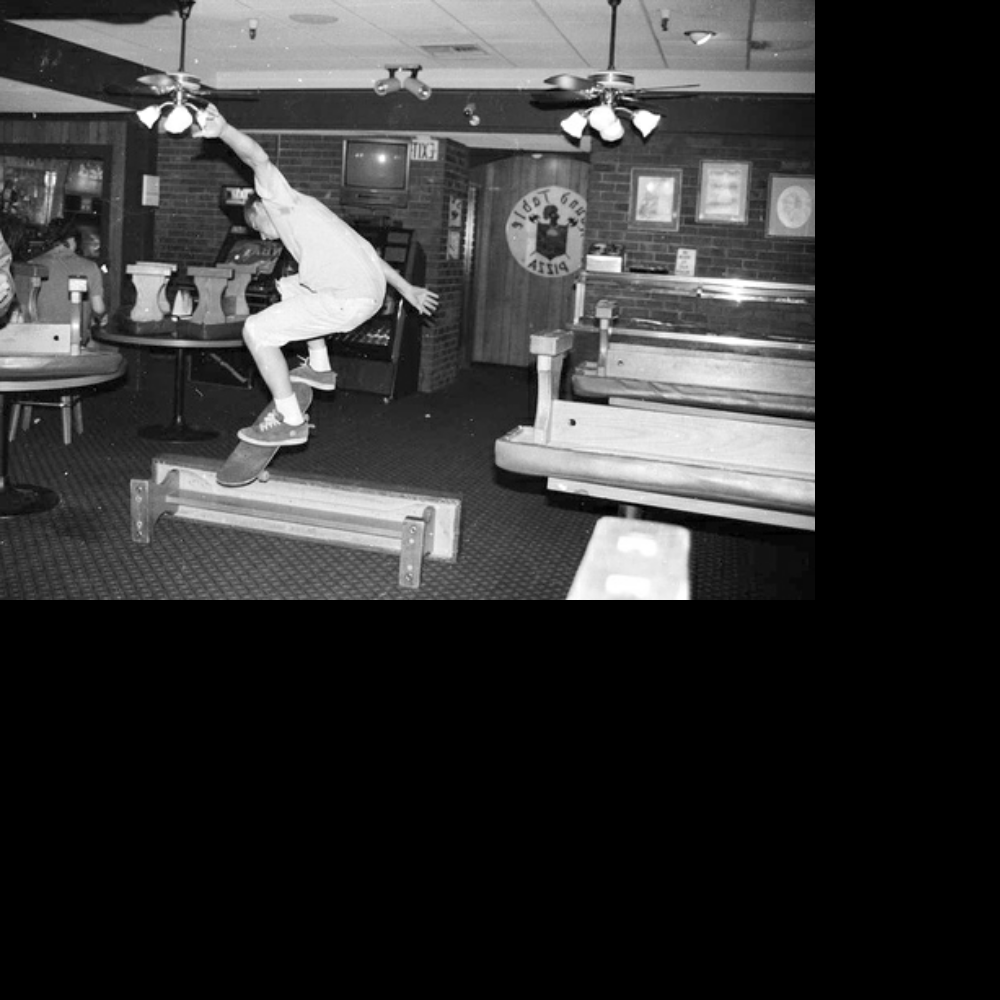

In [23]:
cv2_imshow(img)

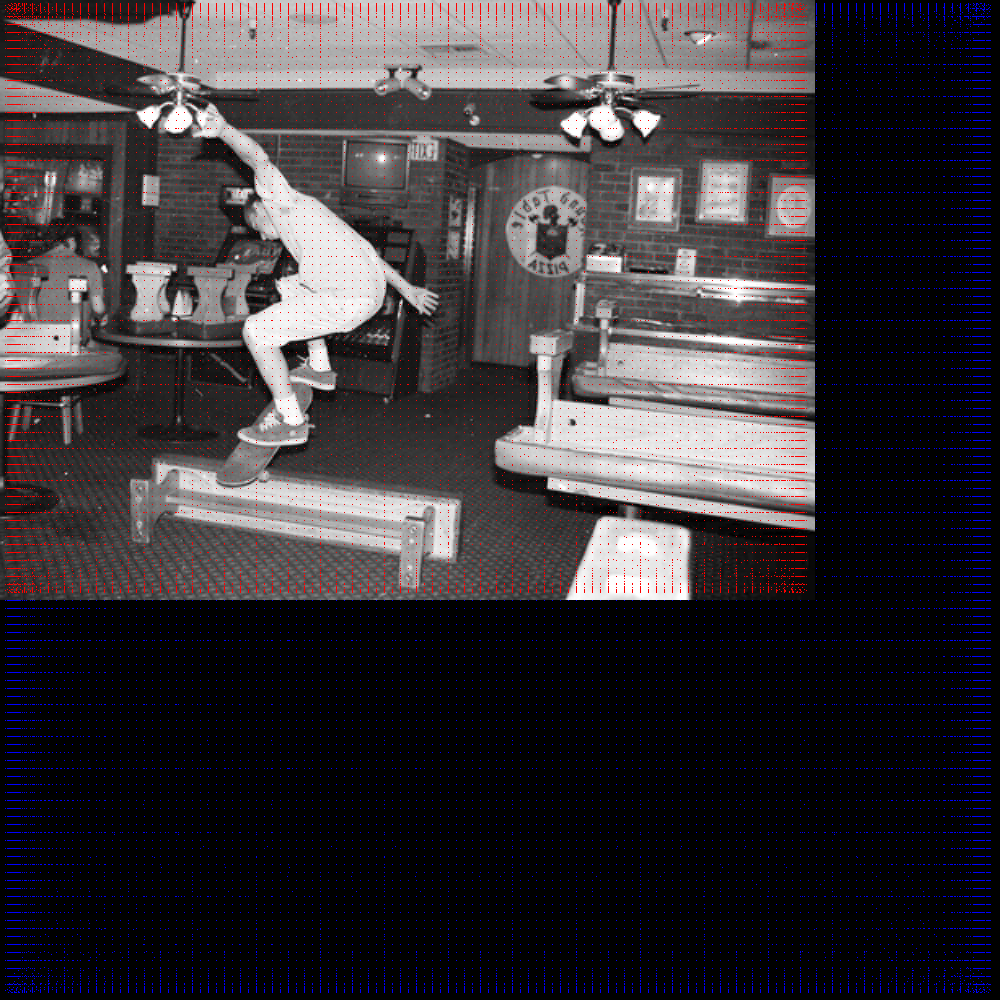

In [24]:
def draw_anchor_centers(img, anchors, in_idx, out_idx):
  """Draw the centers of the anchors. Red for anchors inside the image, blue otherwise
  """
  def _compute_mids(coords):
    mid_x = (coords[:, 0] + coords[:, 2]) / 2.0
    mid_y = (coords[:, 1] + coords[:, 3]) / 2.0
    return np.stack([mid_y, mid_x], axis=1).astype(np.int32)

  def draw_points(img, fill, points, l=1):
    for point in points:
      for dx in range(l):
        for dy in range(l):
          img[point[0] + dx, point[1] + dy] = fill
    return img

  in_point = [0, 0, 255]
  out_point = [255, 0, 0]

  in_mids = _compute_mids(anchors[in_idx])
  out_mids = _compute_mids(anchors[out_idx])

  cv2_imshow(draw_points(draw_points(img, in_point, in_mids), out_point, out_mids))

img_copy = np.copy(img)
draw_anchor_centers(img_copy, anchors, in_idx, out_idx)

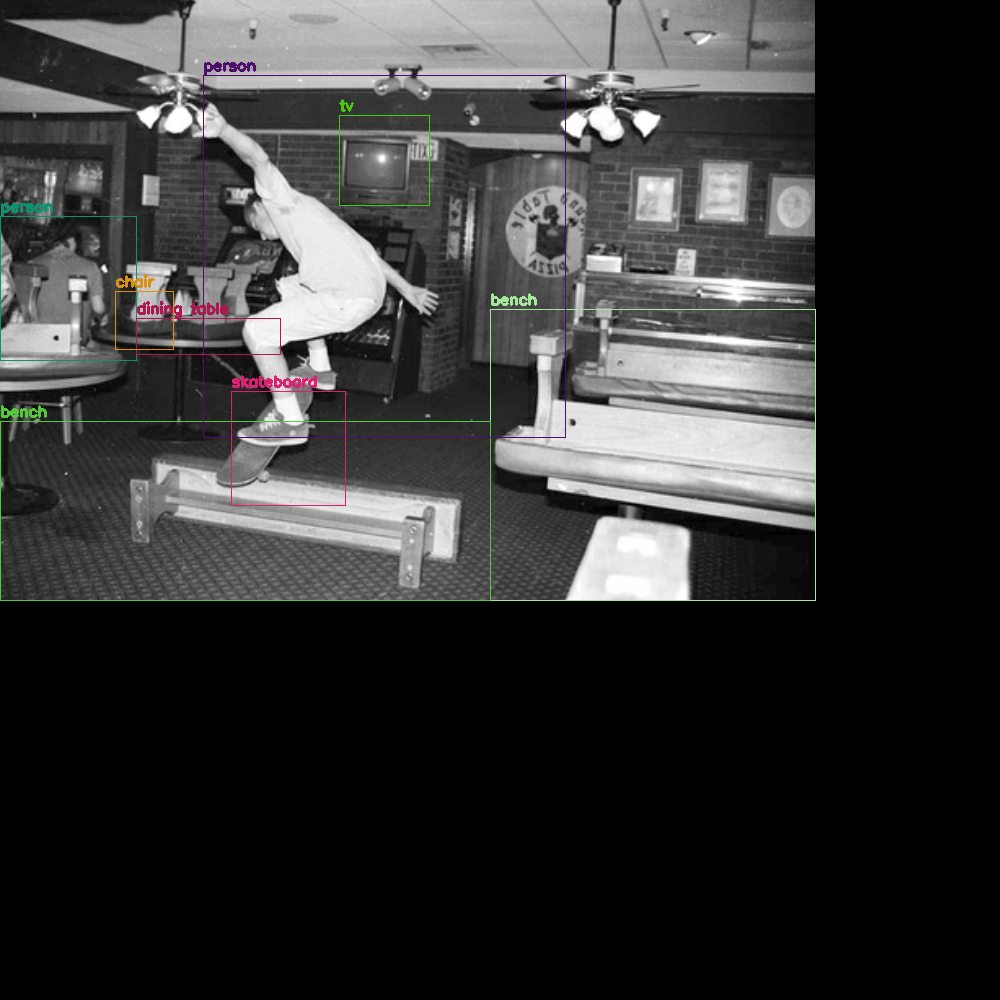

In [25]:
def plot_anchors(img, anchors, anchor_type, labels, nms=False, threshold=0.2):
  anchors = anchors[np.where(anchor_type == 1)]
  labels = labels[np.where(anchor_type == 1)]

  font                   = cv2.FONT_HERSHEY_SIMPLEX
  fontScale              = 0.5
  lineThickness          = 2
  lineType               = cv2.LINE_AA

  if nms:
    ones = jnp.ones(anchors.shape[0], dtype=jnp.float32)
    anchors, idx = non_max_suppression(anchors, ones, threshold)
    labels = labels[list(idx)]

  for idx, anchor in enumerate(anchors):
    color = tuple(np.random.randint(0, 255, size=3))
    color = (int(color[0]), int(color[1]), int(color[2]))

    cv2.putText(img, category_map[labels[idx]], 
      (anchor[0], int(anchor[1] - 5)), 
      font, 
      fontScale,
      color,
      lineThickness,
      lineType)

    cv2.rectangle(img, (anchor[0], anchor[1]), (anchor[2], anchor[3]), color, 1)
    
  cv2_imshow(img)


img_copy = np.copy(img)
plot_anchors(img_copy, anchors, anchor_type, labels, True)

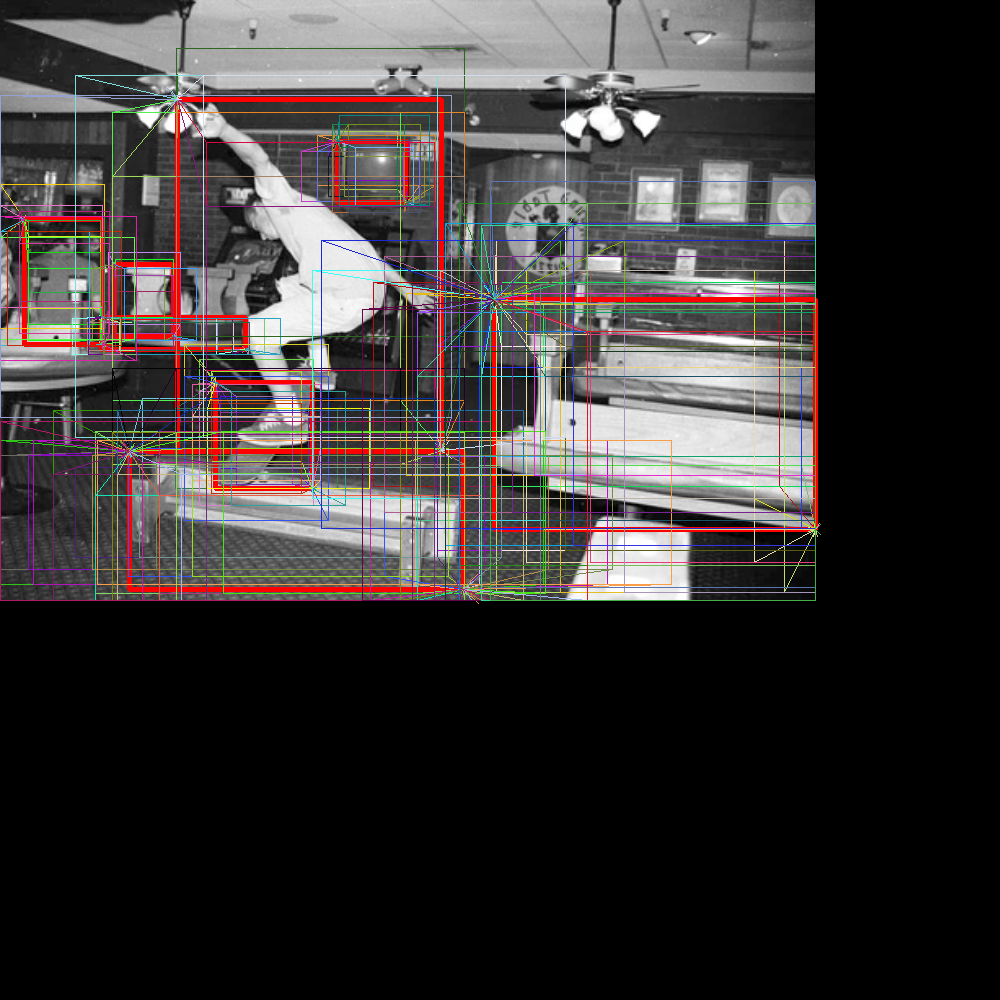

In [26]:
#@title
def plot_regression_targets(img, bboxes, anchors, anchor_type, 
                            regressions, mean=None, std_dev=None):
  bbox_thickness = 3
  anchor_thickness = 1

  # De-standardize the regressions
  if mean is None:
    mean = np.array([0, 0, 0, 0], dtype=np.float32)  
  if std_dev is None:
    std_dev = np.array([0.2, 0.2, 0.2, 0.2], dtype=np.float32)

  widths = anchors[:, 2] - anchors[:, 0]
  heights = anchors[:, 3] - anchors[:, 1]

  regressions = np.multiply(regressions, std_dev) + mean
  regressions[:, 0] = regressions[:, 0] * widths
  regressions[:, 1] = regressions[:, 1] * heights
  regressions[:, 2] = regressions[:, 2] * widths
  regressions[:, 3] = regressions[:, 3] * heights

  # Proceed with plotting the regression targets
  anchors = anchors[np.where(anchor_type == 1)]
  regressions = regressions[np.where(anchor_type == 1)]
  
  # Draw the bboxes
  for bbox in bboxes:
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 0, 255), bbox_thickness)

  # Draw the anchors and their regression targets
  for idx, anchor in enumerate(anchors):
    color = tuple(np.random.randint(0, 255, size=3))
    color = (int(color[0]), int(color[1]), int(color[2]))
    cv2.rectangle(img, (anchor[0], anchor[1]), (anchor[2], anchor[3]), color, anchor_thickness)

    # Draw the target
    t = anchor + regressions[idx]
    cv2.arrowedLine(img, (anchor[0], anchor[1]), (t[0], t[1]), color, anchor_thickness)
    cv2.arrowedLine(img, (anchor[2], anchor[3]), (t[2], t[3]), color, anchor_thickness)

  cv2_imshow(img)


img_copy = np.copy(img)
plot_regression_targets(img_copy, bboxes, anchors, anchor_type, 
                        regression_targets)  

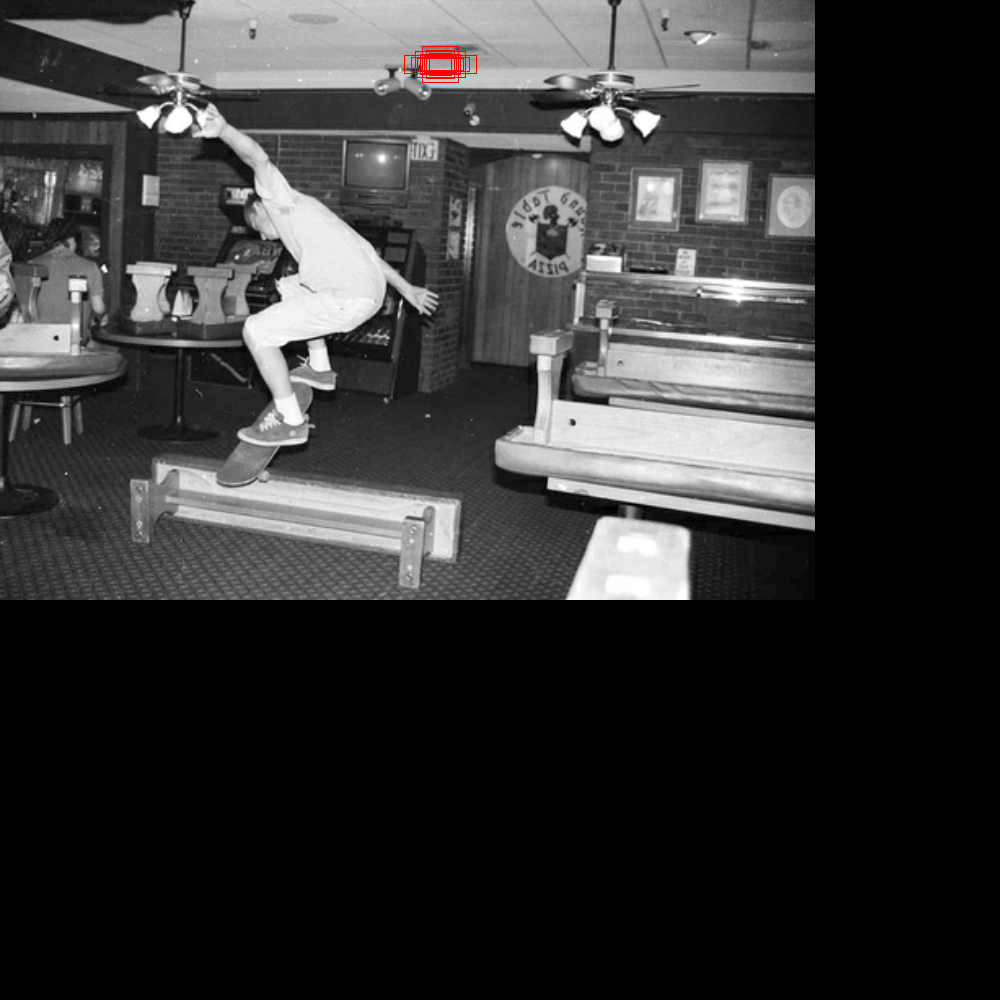

In [27]:
#@title

def draw_some_anchors(img, anchors, start_idx, idx_offset):
  """Draw the centers of the anchors. Red for anchors inside the image, blue otherwise
  """
  bbox_thickness = 1
  # Draw the bboxes
  for idx in start_idx:
    for bbox in anchors[idx:idx + idx_offset]:
      cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 0, 255), bbox_thickness)
  cv2_imshow(img)

img_copy = np.copy(img)
draw_some_anchors(img_copy, anchors, [9495], 9)

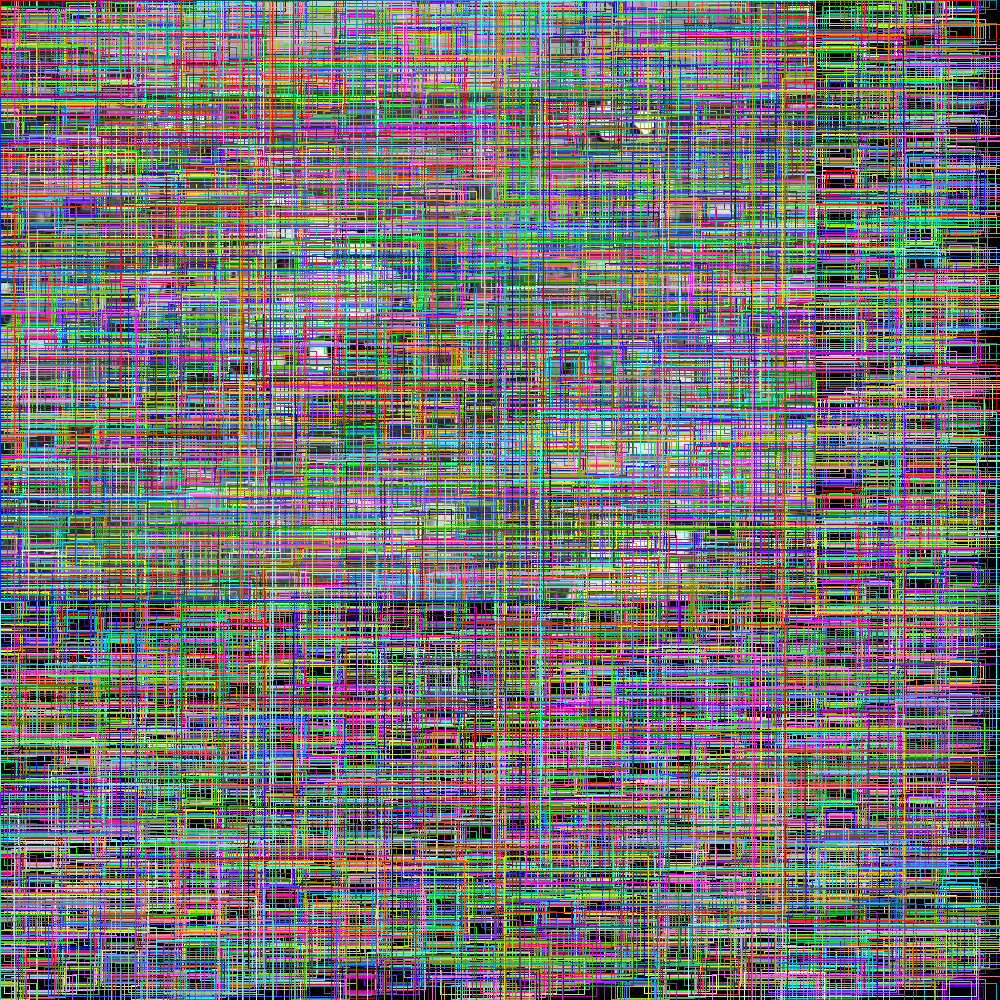

In [28]:
#@title

def draw_all_anchors(img, anchors, increment, count=9):
  """Draw the centers of the anchors.
  """
  bbox_thickness = 1
  # Draw the bboxes
  for idx in range(0, len(anchors), increment):
    for i in range(count):
      bbox = anchors[idx + i]
      color = tuple(np.random.randint(0, 255, size=3))
      color = (int(color[0]), int(color[1]), int(color[2]))
      cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, bbox_thickness)
  cv2_imshow(img)

img_copy = np.copy(img)
draw_all_anchors(img_copy, anchors, 180)